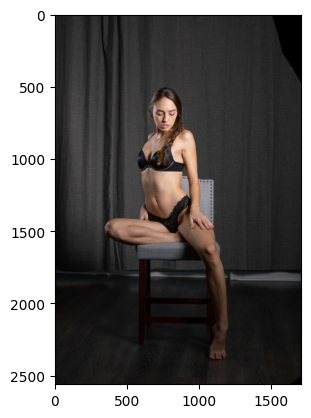

In [30]:
from PIL import Image
import matplotlib.pylab as plt
import requests
import io
from struct import unpack

url = 'https://reference.pictures/wp-content/uploads/2021/02/Reference-Pictures_Figure-Drawing_Chelsie-329-scaled.jpg'
r = requests.get(url)

with io.BytesIO(r.content) as f:
    with Image.open(f) as img:
      plt.figure()
      plt.imshow(img)
      plt.grid(False)
      plt.show()

## Rozkład struktury pliku

In [26]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

data = r.content

huffman_data = []
quant_data = []
DCT_data = []
scan_data = []

file_len = len(data)
while(len(data)>0):
  marker, = unpack(">H", data[0:2])
  offset = file_len - len(data)
  print( offset, "\t", marker_mapping.get(marker))
  if marker == 0xffd8:
    data = data[2:]
  elif marker == 0xffd9:
    break
  else:
    len_chunk, = unpack(">H", data[2:4])
    len_chunk += 2
    chunk = data[4:len_chunk]
    if marker == 0xFFC4:
      huffman_data.append(chunk)
    elif marker == 0xFFDB:
      quant_data.append(chunk)
    elif marker == 0xFFC0:
      DCT_data.append(chunk)
    elif marker == 0xffda:
      scan_data = data[len_chunk:]
      data = data[-2:]
      continue
    data = data[len_chunk:]



0 	 Start of Image
2 	 Application Default Header
20 	 None
72 	 None
7588 	 None
10750 	 None
11448 	 Quantization Table
11517 	 Quantization Table
11586 	 Start of Frame
11605 	 Define Huffman Table
11635 	 Define Huffman Table
11716 	 Define Huffman Table
11744 	 Define Huffman Table
11788 	 Start of Scan
420212 	 End of Image


## Tabele kwantyzacji

In [3]:
def GetArray(type, l, length):
    """
    A convenience function for unpacking an array from bitstream
    """
    s = ""
    for i in range(length):
        s = s + type
    return list(unpack(s, l[:length]))


quant = {}

for data in quant_data:
  (hdr,) = unpack("B", data[0:1])
  quant[hdr] = GetArray("B", data[1 : 1 + 64], 64)
  for x in range(8):
    print(quant[hdr][x:x+8])
  print()

[6, 4, 4, 5, 4, 4, 6, 5]
[4, 4, 5, 4, 4, 6, 5, 5]
[4, 5, 4, 4, 6, 5, 5, 5]
[5, 4, 4, 6, 5, 5, 5, 6]
[4, 4, 6, 5, 5, 5, 6, 6]
[4, 6, 5, 5, 5, 6, 6, 6]
[6, 5, 5, 5, 6, 6, 6, 7]
[5, 5, 5, 6, 6, 6, 7, 9]

[6, 6, 6, 9, 8, 9, 17, 9]
[6, 6, 9, 8, 9, 17, 9, 9]
[6, 9, 8, 9, 17, 9, 9, 17]
[9, 8, 9, 17, 9, 9, 17, 36]
[8, 9, 17, 9, 9, 17, 36, 24]
[9, 17, 9, 9, 17, 36, 24, 20]
[17, 9, 9, 17, 36, 24, 20, 24]
[9, 9, 17, 36, 24, 20, 24, 36]



## Tabele Huffmana

In [6]:
class HuffmanTable:
    """
    A Huffman Table class
    """

    def __init__(self):
        self.root = []
        self.elements = []

    def BitsFromLengths(self, root, element, pos):
        if isinstance(root, list):
            if pos == 0:
                if len(root) < 2:
                    root.append(element)
                    return True
                return False
            for i in [0, 1]:
                if len(root) == i:
                    root.append([])
                if self.BitsFromLengths(root[i], element, pos - 1) == True:
                    return True
        return False

    def GetHuffmanBits(self, lengths, elements):
        self.elements = elements
        ii = 0
        for i in range(len(lengths)):
            for j in range(lengths[i]):
                self.BitsFromLengths(self.root, elements[ii], i)
                ii += 1

    def Find(self, st):
        r = self.root
        while isinstance(r, list):
            r = r[st.GetBit()]
        return r

    def GetCode(self, st):
        while True:
            res = self.Find(st)
            if res == 0:
                return 0
            elif res != -1:
                return res


huffman_tables = {}

for data in huffman_data:
  offset = 0
  (header,) = unpack("B", data[offset : offset + 1])
  offset += 1

  lengths = GetArray("B", data[offset : offset + 16], 16)
  offset += 16
  elements = []
  for i in lengths:
    elements += GetArray("B", data[offset : offset + i], i)
    offset += i

  print("Header: ", header & 0x0F, (header >> 4) & 0x0F)
  print("Lengths: ", lengths)
  print("Number of elements: ", len(elements))

  hf = HuffmanTable()
  hf.GetHuffmanBits(lengths, elements)
  huffman_tables[header] = hf


Header:  0 0
Lengths:  [0, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Number of elements:  9
Header:  0 1
Lengths:  [0, 2, 2, 1, 3, 2, 4, 5, 2, 4, 4, 4, 4, 2, 2, 19]
Number of elements:  60
Header:  1 0
Lengths:  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of elements:  7
Header:  1 1
Lengths:  [1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 3, 0, 3, 1, 1, 1]
Number of elements:  23


## Opis obrazu

In [7]:
quantMapping = []

for data in DCT_data:
  hdr, img_height, img_width, components = unpack(">BHHB",data[0:6])

  for i in range(components):
    id, samp, QtbId = unpack("BBB",data[6+i*3:9+i*3])
    quantMapping.append(QtbId)

  print("size %ix%i" % (img_width,  img_height))
  print(quantMapping)

size 1707x2560
[0, 1, 1]


## Odczyt zawartości obrazu
### Usuwanie dodatkowych zer

In [28]:
def RemoveFF00(data):
    datapro = []
    i = 0
    while(True):
        b,bnext = unpack("BB",data[i:i+2])
        if i < 12:
          print(b, bnext)
        if (b == 0xff):
            if (bnext != 0):
                break
            datapro.append(data[i])
            i+=2
        else:
            datapro.append(data[i])
            i+=1
    return datapro,i

print(len(scan_data))
scan_data, lenchunk = RemoveFF00(scan_data)


408412
252 80
80 176
176 36
36 99
99 30
30 144
144 48
48 234
234 24
24 18
18 40
40 24


In [29]:
class Stream:
    def __init__(self, data):
        self.data = data
        self.pos = 0

    def GetBit(self):
        b = self.data[self.pos >> 3]
        s = 7-(self.pos & 0x7)
        self.pos+=1
        return (b >> s) & 1

    def GetBitN(self, l):
        val = 0
        for i in range(l):
            val = val*2 + self.GetBit()
        return val

st = Stream(scan_data)

In [32]:
image = [0] * (img_width * img_height);

#TODO

## Wyświetlanie obrazu

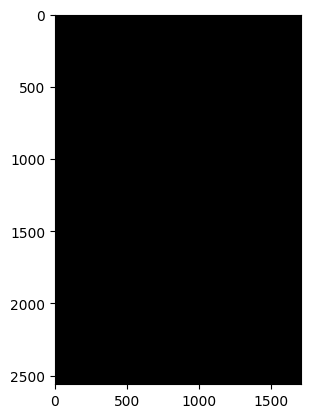

In [31]:
img = Image.new("RGB", (img_width, img_height))
img.putdata(image)

plt.figure()
plt.imshow(img)
plt.grid(False)
plt.show()

## Zadania
Napisz algorytm odczytujący obrazek zapisany w formacie JPEG. W tym celu uzupełnij powyższy kod o fragmenty, realizujące następujące zadania:
1. Odczyt zawartości obrazu z odwróceniem dwuwymiarowej transformacji kosinusowej włącznie. Wykorzystaj fakt, że dwuwymiarowa transformacja jest serią jednowymiarowych przekształceń. (3 pkt.)
2. Napisz szybką, tj. bez wykorzystywania pętli i z wcześniej obliczonymi współczynnikami, wersję ww. metody. (2 pkt.)

## Odnośniki
- https://yasoob.me/posts/understanding-and-writing-jpeg-decoder-in-python/